In [1]:
import base64
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.palettes import Category10, Category20
from bokeh.plotting import figure, show
from sklearn.cluster import KMeans, SpectralClustering

from indigo import *
from indigo.renderer import IndigoRenderer
from indigo.ml.clustering import clustering
from indigo.ml.manifold import reduce_dim

ModuleNotFoundError: No module named 'indigo'

In [5]:
methods = {
    "SpectralClustering": SpectralClustering,
    "KMeans": KMeans
}

In [17]:
DATASET_PATH = "Adrenergic_dataset.csv"

SMILES = "Structure"
ASSAY_1 = "logP"
ASSAY_2 = "AdrA1A_PCHEMBL_VALUE"

In [7]:
indigo = Indigo()

def indigo_fingerprint_short(structure: str) -> np.ndarray:
    indigo.setOption("ignore-stereochemistry-errors", True)
    indigo.setOption("ignore-bad-valence", True)
    m = indigo.loadMolecule(structure)
    m.aromatize()
    indigo.setOption("similarity-type", "ecfp6")
    indigo.setOption("fp-sim-qwords", 24)
    indigo.setOption("fp-ord-qwords", 6)
    indigo.setOption("fp-any-qwords", 6)
    indigo.setOption("fp-tau-qwords", 3)
    indigo.setOption("fp-ext-enabled", True)
    ecfp = np.frombuffer(m.fingerprint("full").toBuffer(), dtype=np.uint8)
    return ecfp

NameError: name 'Indigo' is not defined

In [8]:
renderer = IndigoRenderer(indigo)
indigo.setOption("render-output-format", "svg")
indigo.setOption("render-image-size", 350, 170)


def render_image(smiles: str) -> str:
    mol = indigo.loadMolecule(smiles)
    mol.aromatize()
    svg = renderer.renderToString(mol)
    return "data:image/svg+xml;base64," + base64.b64encode(svg.encode()).decode()

NameError: name 'IndigoRenderer' is not defined

In [9]:
output_notebook()

Loading BokehJS ...

# Experiment for assay_1 values

In [28]:
df = pd.read_csv(DATASET_PATH)

In [18]:
columns = [SMILES, "ID", ASSAY_1]

# CLUSTERING_METHOD = "SpectralClustering"  # basically assigns all the values to one or two clusters
CLUSTERING_METHOD = "KMeans"
N_CLUSTERS = 6  # from 2 to 20

if N_CLUSTERS == 2:
    colors = ["red", "blue"]
elif 2 < N_CLUSTERS <= 10:
    colors = Category10[N_CLUSTERS]
elif 10 < N_CLUSTERS <= 20:
    colors = Category20[N_CLUSTERS]

title = f"Assay value: {ASSAY_1},   Clustering method: {CLUSTERING_METHOD},   Clusters: {N_CLUSTERS}"

In [30]:
dataset = df[[*columns]]
dataset = dataset[dataset[ASSAY_1].notna()]
dataset.head()

,Structure,ID,logP
0,CC\C(=C(\CC)/c1ccc(O)cc1)\c2ccc(O)cc2,CHEMBL411,4.871
1,CSc1ccc2Sc3ccccc3N(CCC4CCCCN4C)c2c1,CHEMBL479,5.900
2,COc1cccc(CCN2C3C4C5CC6C7C5C3C7C2(O)C46)c1,CHEMBL2205811,3.040
3,COc1cc(CN[C@H]2C3C4CC5C6C4CC3C6C25)cc(OC)c1OC,CHEMBL2432051,3.380
4,COc1cccc(CCN2C3C4C5CC6C7C5C3C7C2(O)C46)c1OC,CHEMBL2205813,2.899


In [31]:
assay_1_values = dataset[ASSAY_1].values.reshape(len(dataset[ASSAY_1].values), 1)
clusters_1 = clustering(assay_1_values, method=methods[CLUSTERING_METHOD], n_clusters=N_CLUSTERS)

In [32]:
fingerprints = [indigo_fingerprint_short(s) for s in dataset[SMILES]]
coordinates = reduce_dim(fingerprints, random_state=42, min_dist=0.8, n_neighbors=15)

In [33]:
x = [c[0] for c in coordinates]
y = [c[1] for c in coordinates]

In [34]:
def clustering_plot(
    title: str,
    x: List[float], 
    y: List[float], 
    ids: List[str], 
    smiles: List[str], 
    clusters: List[int],
    colors: List[str]
):
    df = pd.DataFrame({'x': x, 'y': y})
    df["id"] = ids
    df["image"] = [render_image(smiles) for smiles in smiles]
    df["color"] = [colors[i] for i in clusters]
    datasource = ColumnDataSource(df)
    
    plot_figure = figure(
        title=title,
        tools="pan, wheel_zoom, reset",
)
    plot_figure.add_tools(
        HoverTool(
        tooltips="""
            <div>
            <div>
            <img src='@image' style='float: left; margin: 10px 10px 10px 10px'/>
            </div>
            <div>
            <span style='font-size: 12px; color: #224499'>Compound:</span>
            <span style='font-size: 12px'>@id</span>
            </div>
            </div>
            """
        )
    )
    
    plot_figure.circle(
        "x",
        "y",
        color="color",
        source=datasource,
    )
    return plot_figure

In [24]:
# x = [1,2,3,5]
# y = [1,2,3,5]
# clusters_1 = [0,0,0,1]
# colors = ["red", "blue"]

In [39]:
def simple_plot(x: List[float], y: List[float], clusters: List[int], colors: List[str], title: str):
    clusterized_colors = [colors[cl] for cl in clusters]
    plt.title(title)
    plt.scatter(x, y, c=clusterized_colors)
    plt.show()

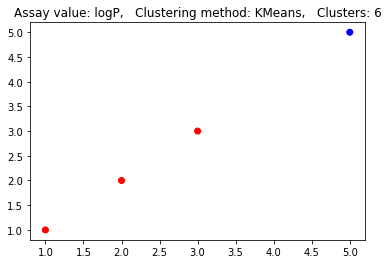

In [40]:
simple_plot(x, y, clusters_1, colors, title)

In [ ]:
cl_plot1 = clustering_plot(title, x, y, dataset["ID"], dataset[SMILES], clusters_1, colors)
show(cl_plot1)

# Experiment for assay_2 values

In [36]:
cols = [SMILES, "ID", ASSAY_2]

CLUSTERING_METHOD_2 = "SpectralClustering"
# CLUSTERING_METHOD_2 = "KMeans"
N_CLUSTERS_2 = 4

if N_CLUSTERS_2 == 2:
    colors_2 = ["red", "blue"]
elif 2 < N_CLUSTERS_2 <= 10:
    colors_2 = Category10[N_CLUSTERS_2]
elif 10 < N_CLUSTERS_2 <= 20:
    colors_2 = Category20[N_CLUSTERS_2]
    
title_2 = f"Assay value: {ASSAY_2}, Clustering method: {CLUSTERING_METHOD_2}, Clusters: {N_CLUSTERS_2}"

In [37]:
ds = df[[*cols]]
ds = ds[ds[ASSAY_2].notna()]
ds.head()

,Structure,ID,AdrA1A_PCHEMBL_VALUE
7,CNC(=O)C(CCN1CCC(O)(CC1)c2ccc(Cl)cc2)(c3ccccc3...,CHEMBL1627,8.00
12,Cc1ccc2c(cccc2n1)N3CCN(CCc4cccc5c4OCc6c(ncn56)...,CHEMBL1241913,8.56
13,COc1ccccc1OCCNCC2CSC(S2)(c3ccccc3)c4ccccc4,CHEMBL1086156,7.45
16,O[C@H]1[C@H](CC[C@@H]1Oc2ccccc2)NC[C@H]3COc4cc...,CHEMBL135974,6.41
19,COc1cccc(OC)c1OCCNC[C@H]2COc3ccccc3O2,CHEMBL1182155,9.39


In [38]:
assay_2_values = ds[ASSAY_2].values.reshape(len(ds[ASSAY_2].values), 1)
clusters_2 = clustering(assay_2_values, method=methods[CLUSTERING_METHOD_2], n_clusters=N_CLUSTERS_2)

In [39]:
fp = [indigo_fingerprint_short(s) for s in ds[SMILES]]
coords = reduce_dim(fp, random_state=42, min_dist=0.5, n_neighbors=15)

x2 = [c[0] for c in coords]
y2 = [c[1] for c in coords]

In [ ]:
cl_plot2 = clustering_plot(title_2, x2, y2, ds["ID"], ds[SMILES], clusters_2, colors_2)
show(cl_plot2)